# PREDICTION OF POKEMON TYPES USING POKEMON DATASET 


<img src="pokemon.png" style="width:500px">

The dataset used in this project contains 800 different pokemons which belong to seven generations. The project focuses on predicting the types of pokemon and whether 
the pokemon are legendary or not based on machine learning techniques. In particular, we will take advantage of:
    1. Knn algorithm
    2. Neural  network

There are in total, 18 different types of pokemon that are present in the dataset. The pokemon is said to be legendary if the value is 1
and is not legendary if the value is 0. The features influencing the type of the pokemon are the abilities and the strength of the pokemon
against other pokemon. The features that determine if the pokemon is legendary or not is the attack,defense,special attack,special defense,HP,
height,weight and experience. 640 data points are used for training and 160 for testing the model. 
Alright, lets catch 'em all!

# Loading the data

In [1]:
# Import initial libraries and settings
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

#import the data
data=pd.read_csv("pokemon.csv")

data1=data.drop(['japanese_name','percentage_male','pokedex_number','type2','classfication'],axis=1)
data1.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,height_m,hp,name,sp_attack,sp_defense,speed,type1,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0.7,45,Bulbasaur,65,65,45,grass,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,1.0,60,Ivysaur,80,80,60,grass,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,2.0,80,Venusaur,122,120,80,grass,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0.6,39,Charmander,60,50,65,fire,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,1.1,58,Charmeleon,80,65,80,fire,19.0,1,0


# Data visualization
What is the proportion of each type of pokemon in our dataset?


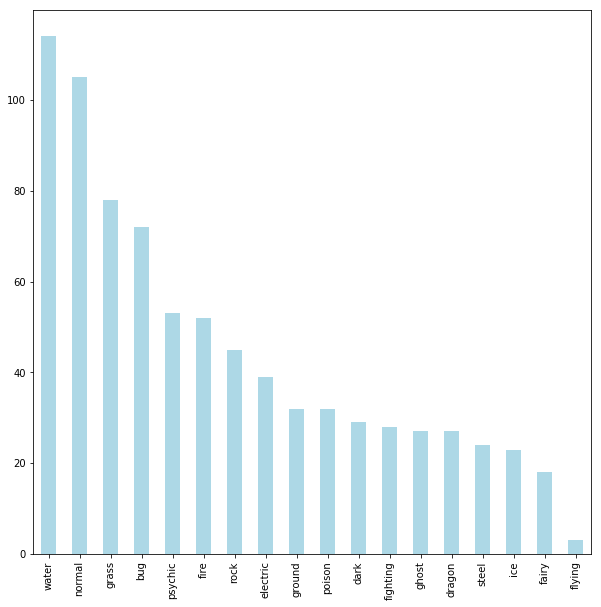

In [2]:
data['type1'].value_counts().plot(kind='bar', color='lightblue',figsize=(10,10))

There are 18 types of pokemon which are water,normal,grass,bug,psychic,fire,rock,electric,groud,poison,dark,fighting,dragon,ghost,steel,ice,fairy,flying. Water type pokemon is the majority type of pokemon.

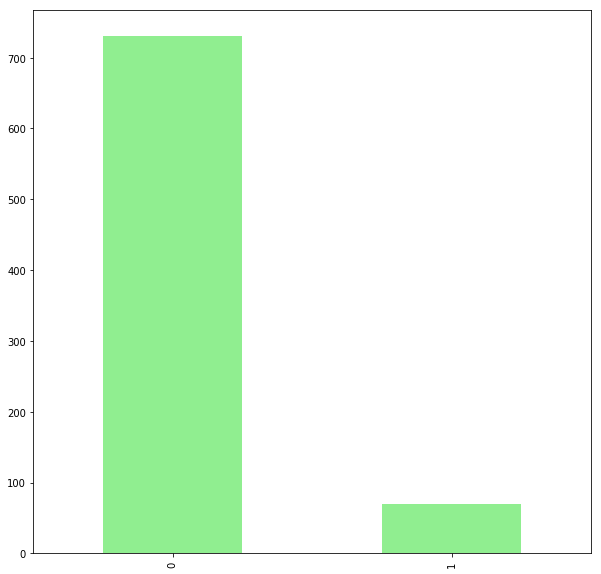

In [3]:
data['is_legendary'].value_counts().plot(kind='bar', color='lightgreen',figsize=(10,10))

This is why legendary pokemon are so rare. 

### Features vs legendary

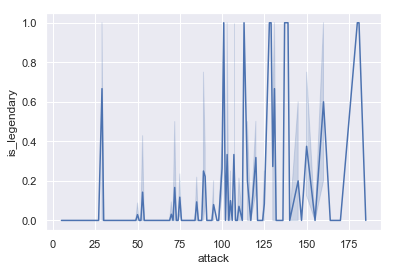

In [4]:
sns.set()
ax = sns.lineplot(x="attack", y="is_legendary", data=data)

Using seaborn lineplot the graph of attack with the target is_legendary is plotted above. It indicates that the legendary pokemon will have a higher value for attack, which makes it stronger compared to the other pokemon.

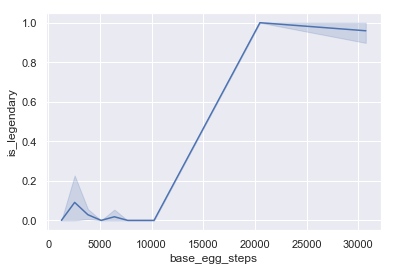

In [5]:
sns.set()
ax = sns.lineplot(x="base_egg_steps", y="is_legendary", data=data)

The above graph of base_egg_steps(The number of Egg cycles required to hatch an Egg is stored in the same number that would be the friendship value for normal Pokémon.) and target indicated that the number of egg steps required are more in case of legendary type.

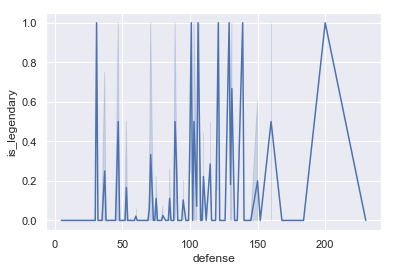

In [6]:
sns.set()
ax = sns.lineplot(x="defense", y="is_legendary", data=data)

The graph shows that normal pokemon have lower defense rates than the legendary ones.

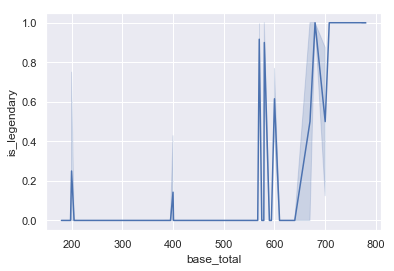

In [7]:
sns.set()
ax = sns.lineplot(x="base_total", y="is_legendary", data=data)

Base stats are an important defining characteristic of each Pokémon species. The total base stats are higher in pokemon which are legendary since they are stronger than normal pokemon.

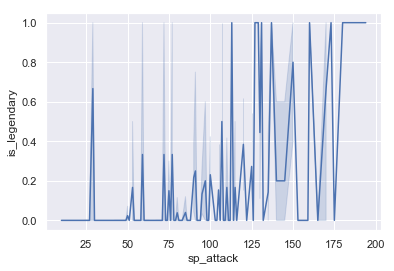

In [8]:
sns.set()
ax = sns.lineplot(x="sp_attack", y="is_legendary", data=data)

Legendary pokemon exhibit special attack and defense features when compared to normal ones.

# Data preprocessing

Here, the abilities of the pokemon are a list of string values.These are to be converted into binary equivalents.
Hence,multilabelbinarizer can be used which tranforms the list into a binary matrix having 227 columns since there are 227 distinct values in the list.

In [2]:
ability=[]
for i in data1['abilities']:
    x = i[1:-2]
    
    x = x.replace("'","")
   
    x= x.replace(" ", "")
   
    y = x.split(',')
    
    ability.append(y)
df = pd.DataFrame(
    {'abilities':
        ability
    }, columns=['abilities'])

s = df['abilities']

mlb = MultiLabelBinarizer()

X=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
x=pd.DataFrame(X)

### Principal Component Analysis (PCA)

PCA is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set. Since all 227 columns are important, I have used PCA to tranform it into 10 columns.

In [3]:
newdf = pd.concat([x,data1],axis=1)


pca = PCA()  
features1 = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
explained_variance
pca = PCA(n_components=10)  
features1 = pca.fit_transform(features1)

Upon observing the dataset,there were few values with Nan which indicates missing values. We have to replace these values and this can be done by taking the mean of the row and replacing Nan with this mean. Furhter, few columns are dropped in order to get the clean dataset. 

In [4]:
features=newdf.drop(['type1','name','abilities'],axis=1)
features.fillna(features.mean(), inplace=True)



Okay, lets get to the algorithms. Since there are two target values considered, two models are built in both neural network and KNN. We begin with predicting the accuracy using KNN algorithm.

## KNN, I choose you! <img src="pokeballgif.gif" style="width:450px">

We will first predict the accuracy for the target 'is_legendary'. The various features affecting this can be determined by the correlation. The pearson correlation and the heat map is as follows,

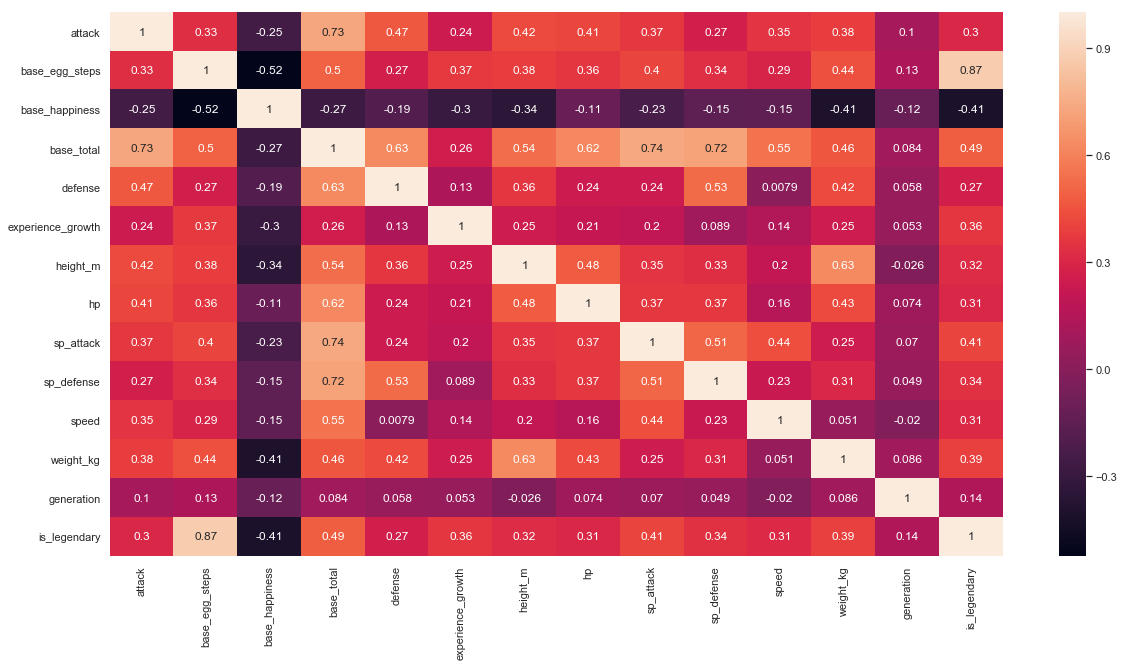

In [15]:
data2=data1.drop(['abilities','against_bug','against_dark','against_dragon','against_electric','against_fairy','against_fight','against_fire','against_flying','against_ghost','against_grass','against_ground','against_ice','against_normal','against_poison','against_psychic','against_rock','against_steel','against_water'],axis=1)
data2
abs(data2['is_legendary']).sort_values(ascending=False)
corr = data2.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True)
plt.show()


We see that there is some correlation with the following stats
    Base egg steps, defense, attack,base total, special attack and special defense.
    
Keeping this in view, we will select the necessary features like attack, defense, base_egg_steps,hp,sp_attack,sp_defense adn base_total. The remaining features are dropped.

In [63]:
features2= pd.DataFrame(features.iloc[:,245:-2])
features2=features2.drop(['capture_rate','experience_growth','speed','weight_kg','base_happiness','height_m'],axis=1)
features2=pd.DataFrame(features2)
features2.head()

,attack,base_egg_steps,base_total,defense,hp,sp_attack,sp_defense
0,49,5120,318,49,45,65,65
1,62,5120,405,63,60,80,80
2,100,5120,625,123,80,122,120
3,52,5120,309,43,39,60,50
4,64,5120,405,58,58,80,65


The features that are most correlated with the target is chosen and the rest are dropped. 

In [26]:
#normalization of the data.
features2=(features2-features2.min())/(features2.max()-features2.min())
features2=np.array(features2)

In [27]:
target=pd.DataFrame(newdf['is_legendary'])
target=np.array(target)
xtrain, xtest, ytrain, ytest = train_test_split(features2,target, test_size=0.3)

features2 contains all the necessary features for our prediction and target contains 'is_legendary'. 70% of the data is used on training and 30% for testing.
The Knn algorithm is shown below. 15 neighbours are considered.

In [33]:
def euclid_distance(train_point, given_point):
    distance = np.sum((train_point-given_point)**2)
    return np.sqrt(distance)


# Calculate distance from a given point to all other points
# and keep track of the respective classes for those distances
# and eventually return sorted list of distances
def calc_distance_from_all(all_points, given_point, predictions):
    all_distances = []
    for i, each in enumerate(all_points):
        distance = euclid_distance(each, given_point)
        all_distances.append((distance,int(predictions[i])))
    all_distances.sort(key=lambda tup: tup[0])
    return all_distances



# Get the "n" defined neighbours from a list of sorted distances
def get_neighbours(distances, count):
    return distances[:count]




# Takes a given point and predicts the class based on all other points
def predict(all_points, given_point, predictions):
    distances = calc_distance_from_all(all_points,given_point,predictions)
    neighbours = get_neighbours(distances, 15)
    
    op = [row[-1] for row in neighbours]
    prediction = max(set(op), key=op.count)
    return prediction



# Get how accurate our system is based on a new set of test points
# for which we already know the right answer to
def accuracy(basex, basey, testx, testy):
    correct = 0 
    
    for i in range(len(testx)):
        p = predict(basex, testx[i], basey)
        if p == testy[i]:
            correct += 1
            
    return f"Accuracy: {correct*100/len(testy)}%"

In [29]:
accuracy(xtrain,ytrain,xtest,ytest)

'Accuracy: 98.7551867219917%'

The accuracy for predicting the legendary pokemon is 98.75%. 

We will now predict the accuracy for the target 'type1' to predict the type of the pokemon. The feautures needed for this are the ability of the pokemon and the strength against other types of pokemon. We have already preprocessed the data and used PCA to convert the 227 columns into 10,which is present in a variable called features1. features3 contains the strength of the pokemon against other pokemon. 

In [17]:
features3= pd.DataFrame(features.iloc[:,227:-15])
features1=pd.DataFrame(features1)
features3=pd.DataFrame(features3)
ft=pd.concat([features1,features3],axis=1)
ft=(ft-ft.min())/(ft.max()-ft.min())
ft=np.array(ft)



The target consists of string values which have to be converted into integers. Thus,cat.codes is used to convert the string classes into integer class values.

In [40]:
target1=newdf['type1']
target=target1.astype("category").cat.codes
target=np.array(target)
xtrain, xtest, ytrain, ytest = train_test_split(ft,target, test_size=0.3)


In [41]:
accuracy(xtrain,ytrain,xtest,ytest)

'Accuracy: 76.34854771784232%'

Upon execution of the KNN algorithm for the new set of features and target, the accuracy to predict the type is 76.34% with 15 neighbours. 
KNN algorithm gives a good accuracy for both the targets. 

## Algorithm conclusions

It is observed that the KNN algorithm fits well with both the target giving an accuracy of more than 75%. 

Now, let us explore neural networks for our data. 

# Good job KNN. Lets go Neural networks!

### Training the data.
As with KNN, we will build two networks for predicting type and legendary pokemon. We will start by building a model with the target as 'type1' and features as abilities and strength against other pokemon. The features1 contains the 10 columns obtained after PCA and features 2 contains the strenghts of pokemon against other types of pokemon.
ft is the concatenation of features1 and features2 which is then normalized and converted into an array.

In [5]:
features.fillna(features.mean(), inplace=True)
features2= pd.DataFrame(features.iloc[:,227:-15])
features1=pd.DataFrame(features1)
features2=pd.DataFrame(features2)
ft=pd.concat([features1,features2],axis=1)

ft=(ft-ft.min())/(ft.max()-ft.min())
ft=np.array(ft)

The target being string values has to be converted into binary which is done using get_dummies(). The data is split as 70% training and 30% test data. 

In [6]:
target1=pd.DataFrame(newdf['type1'])
target1=pd.get_dummies(target1)
target=np.array(target1)
xtrain,xtest,ytrain,ytest=train_test_split(ft,target, test_size=0.3)

Using tensorflow a neural network consisting of one input layer, one hidden layer and one output layer. The activation functions used are tanh and softmax. Since 18 classes are present there aare 18 nodes in the output layer.

In [7]:
model = keras.Sequential([
    keras.layers.Dense(106, activation=tf.nn.tanh,
                       input_shape=(xtrain.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(18, activation=tf.nn.softmax)
])

In [8]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [9]:
history= model.fit(xtrain, ytrain, epochs=30, validation_split=0.2, verbose=2)

Train on 448 samples, validate on 112 samples
Epoch 1/30
 - 0s - loss: 2.7823 - acc: 0.1741 - val_loss: 2.6854 - val_acc: 0.2857
Epoch 2/30
 - 0s - loss: 2.5697 - acc: 0.2344 - val_loss: 2.5679 - val_acc: 0.3036
Epoch 3/30
 - 0s - loss: 2.4296 - acc: 0.3170 - val_loss: 2.4509 - val_acc: 0.3393
Epoch 4/30
 - 0s - loss: 2.2938 - acc: 0.4241 - val_loss: 2.3276 - val_acc: 0.4196
Epoch 5/30
 - 0s - loss: 2.1451 - acc: 0.4933 - val_loss: 2.1886 - val_acc: 0.4375
Epoch 6/30
 - 0s - loss: 1.9775 - acc: 0.5402 - val_loss: 2.0324 - val_acc: 0.4911
Epoch 7/30
 - 0s - loss: 1.8142 - acc: 0.5759 - val_loss: 1.8724 - val_acc: 0.5446
Epoch 8/30
 - 0s - loss: 1.6478 - acc: 0.6228 - val_loss: 1.7226 - val_acc: 0.5625
Epoch 9/30
 - 0s - loss: 1.4861 - acc: 0.6585 - val_loss: 1.5881 - val_acc: 0.5714
Epoch 10/30
 - 0s - loss: 1.3493 - acc: 0.6853 - val_loss: 1.4557 - val_acc: 0.6250
Epoch 11/30
 - 0s - loss: 1.2197 - acc: 0.7009 - val_loss: 1.3419 - val_acc: 0.6518
Epoch 12/30
 - 0s - loss: 1.1062 - acc:

In [11]:
model.fit(xtest,ytest,epochs=30)

Epoch 1/30
241/241 [==============================] - 0s 156us/step - loss: 0.5409 - acc: 0.8755
Epoch 2/30
241/241 [==============================] - 0s 62us/step - loss: 0.4977 - acc: 0.8963
Epoch 3/30
241/241 [==============================] - 0s 62us/step - loss: 0.4704 - acc: 0.9004
Epoch 4/30
241/241 [==============================] - 0s 62us/step - loss: 0.4466 - acc: 0.9004
Epoch 5/30
241/241 [==============================] - 0s 62us/step - loss: 0.4273 - acc: 0.9004
Epoch 6/30
241/241 [==============================] - 0s 62us/step - loss: 0.4072 - acc: 0.9170
Epoch 7/30
241/241 [==============================] - 0s 52us/step - loss: 0.3906 - acc: 0.9212
Epoch 8/30
241/241 [==============================] - 0s 52us/step - loss: 0.3711 - acc: 0.9295
Epoch 9/30
241/241 [==============================] - 0s 104us/step - loss: 0.3573 - acc: 0.9378
Epoch 10/30
241/241 [==============================] - 0s 62us/step - loss: 0.3448 - acc: 0.9419
Epoch 11/30
241/241 [================

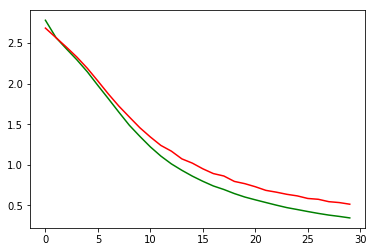

In [10]:
plt.plot(history.epoch, history.history['loss'], 'g')
plt.plot(history.epoch, history.history['val_loss'],'r')

In [12]:
loss, accuracy = model.evaluate(xtest,ytest)
print(accuracy)

241/241 [==============================] - 0s 145us/step
0.970954356846473


The neural network gives an accuracy of 99.5% on the test dataset for type1. The training set is divided as training and validation sets where 80% is for training the data and 20% is for validating the data. The above graph compares the training and validation losses. 

Let us now build a model for predicting the legendary type of pokemon. 

In [5]:
features2= pd.DataFrame(features.iloc[:,245:-2])
features2=features2.drop(['capture_rate'],axis=1)
features2=(features2-features2.min())/(features2.max()-features2.min())
features2=np.array(features2)

In [7]:
target2=pd.DataFrame(newdf['is_legendary'])
target=np.array(target2)
#since is_legendary contains only integers, they are converted into cateogrical values 
from keras.utils import to_categorical
target = to_categorical(target)
xtrain, xtest, ytrain, ytest = train_test_split(features2,target, test_size=0.3)




In [8]:
model = keras.Sequential([
    keras.layers.Dense(106, activation=tf.nn.tanh,
                       input_shape=(xtrain.shape[1],)),
    keras.layers.Dense(67, activation=tf.nn.tanh),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])



In [9]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [10]:
history2= model.fit(xtrain, ytrain, epochs=35, validation_split=0.2, verbose=2)

Train on 448 samples, validate on 112 samples
Epoch 1/35
 - 0s - loss: 0.8477 - acc: 0.2746 - val_loss: 0.5508 - val_acc: 0.9196
Epoch 2/35
 - 0s - loss: 0.4299 - acc: 0.9085 - val_loss: 0.3165 - val_acc: 0.9286
Epoch 3/35
 - 0s - loss: 0.3295 - acc: 0.9085 - val_loss: 0.2720 - val_acc: 0.9286
Epoch 4/35
 - 0s - loss: 0.3117 - acc: 0.9085 - val_loss: 0.2571 - val_acc: 0.9286
Epoch 5/35
 - 0s - loss: 0.3005 - acc: 0.9085 - val_loss: 0.2483 - val_acc: 0.9286
Epoch 6/35
 - 0s - loss: 0.2907 - acc: 0.9085 - val_loss: 0.2404 - val_acc: 0.9286
Epoch 7/35
 - 0s - loss: 0.2813 - acc: 0.9085 - val_loss: 0.2329 - val_acc: 0.9286
Epoch 8/35
 - 0s - loss: 0.2725 - acc: 0.9085 - val_loss: 0.2256 - val_acc: 0.9286
Epoch 9/35
 - 0s - loss: 0.2635 - acc: 0.9085 - val_loss: 0.2183 - val_acc: 0.9286
Epoch 10/35
 - 0s - loss: 0.2553 - acc: 0.9085 - val_loss: 0.2112 - val_acc: 0.9286
Epoch 11/35
 - 0s - loss: 0.2463 - acc: 0.9085 - val_loss: 0.2037 - val_acc: 0.9286
Epoch 12/35
 - 0s - loss: 0.2391 - acc:

In [11]:
model.fit(xtest,ytest,epochs=20)

Epoch 1/20
241/241 [==============================] - 0s 73us/step - loss: 0.1176 - acc: 0.9668
Epoch 2/20
241/241 [==============================] - 0s 62us/step - loss: 0.1156 - acc: 0.9627
Epoch 3/20
241/241 [==============================] - 0s 52us/step - loss: 0.1144 - acc: 0.9585
Epoch 4/20
241/241 [==============================] - 0s 52us/step - loss: 0.1130 - acc: 0.9544
Epoch 5/20
241/241 [==============================] - 0s 52us/step - loss: 0.1119 - acc: 0.9544
Epoch 6/20
241/241 [==============================] - 0s 52us/step - loss: 0.1109 - acc: 0.9544
Epoch 7/20
241/241 [==============================] - 0s 52us/step - loss: 0.1101 - acc: 0.9544
Epoch 8/20
241/241 [==============================] - 0s 41us/step - loss: 0.1094 - acc: 0.9544
Epoch 9/20
241/241 [==============================] - 0s 52us/step - loss: 0.1087 - acc: 0.9544
Epoch 10/20
241/241 [==============================] - 0s 83us/step - loss: 0.1080 - acc: 0.9544
Epoch 11/20
241/241 [==================

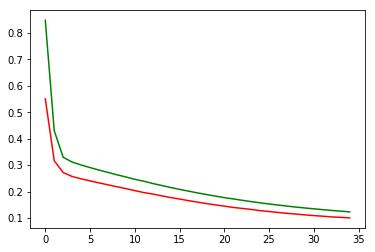

In [12]:
plt.plot(history2.epoch, history2.history['loss'], 'g')
plt.plot(history2.epoch, history2.history['val_loss'],'r')

In [13]:
loss, accuracy = model.evaluate(xtest,ytest)
print(accuracy)

241/241 [==============================] - 0s 166us/step
0.9626556019070732


## Algorithm conclusions

The two algorithms gives an accuracy of more than 75% but the neural network gives a better accuracy when compared to KNN on both targets. 